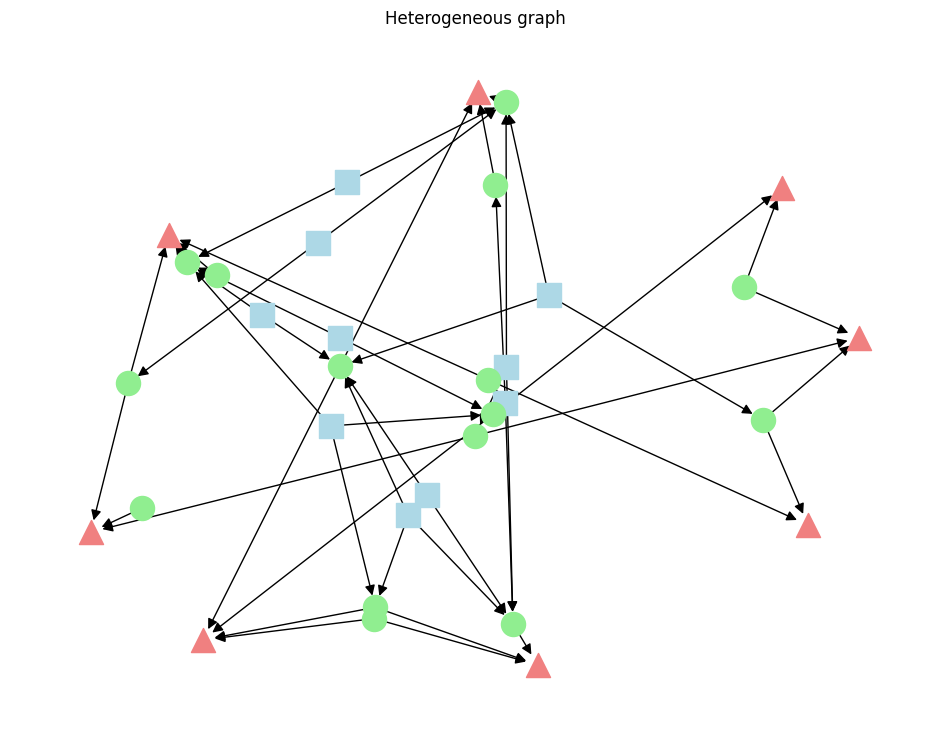

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Create directed graph
G = nx.DiGraph()

# Number of nodes per type
num_squares = 10
num_circles = 15
num_triangles = 8

# Add squares
squares = [f'square{i}' for i in range(num_squares)]
for s in squares:
    G.add_node(s, shape='square')

# Add circles
circles = [f'circle{i}' for i in range(num_circles)]
for c in circles:
    G.add_node(c, shape='circle')

# Add triangles
triangles = [f'triangle{i}' for i in range(num_triangles)]
for t in triangles:
    G.add_node(t, shape='triangle')

# Add edges: squares -> circles
for s in squares:
    # each square points to 1-3 random circles
    targets = random.sample(circles, k=random.randint(1, 3))
    for c in targets:
        G.add_edge(s, c)

# Add edges: circles -> triangles
for c in circles:
    # each circle points to 1-2 random triangles
    targets = random.sample(triangles, k=random.randint(1, 2))
    for t in targets:
        G.add_edge(c, t)

# Visualization setup
pos = nx.spring_layout(G, seed=42)  # fixed seed for reproducibility

square_nodes = [n for n, attr in G.nodes(data=True) if attr['shape'] == 'square']
circle_nodes = [n for n, attr in G.nodes(data=True) if attr['shape'] == 'circle']
triangle_nodes = [n for n, attr in G.nodes(data=True) if attr['shape'] == 'triangle']

plt.figure(figsize=(12, 9))

# Draw nodes by shape
nx.draw_networkx_nodes(G, pos, nodelist=square_nodes, node_shape='s', node_color='lightblue', label='Squares')
nx.draw_networkx_nodes(G, pos, nodelist=circle_nodes, node_shape='o', node_color='lightgreen', label='Circles')
nx.draw_networkx_nodes(G, pos, nodelist=triangle_nodes, node_shape='^', node_color='lightcoral', label='Triangles')

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15)

# No labels as you requested
#plt.legend(scatterpoints=1)
plt.axis('off')
plt.title("Heterogeneous graph")
plt.show()


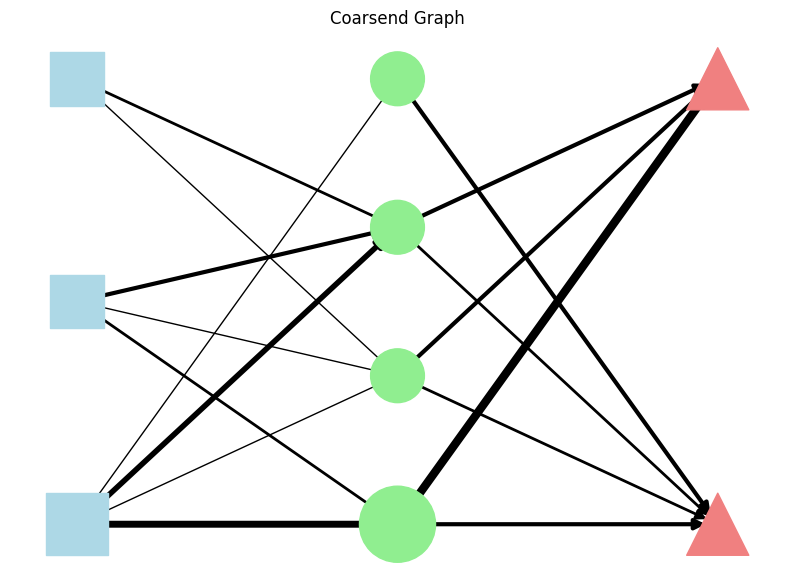

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Original graph creation (same as your code)
G = nx.DiGraph()

num_squares = 10
num_circles = 15
num_triangles = 8

squares = [f'square{i}' for i in range(num_squares)]
for s in squares:
    G.add_node(s, shape='square')

circles = [f'circle{i}' for i in range(num_circles)]
for c in circles:
    G.add_node(c, shape='circle')

triangles = [f'triangle{i}' for i in range(num_triangles)]
for t in triangles:
    G.add_node(t, shape='triangle')

for s in squares:
    targets = random.sample(circles, k=random.randint(1, 3))
    for c in targets:
        G.add_edge(s, c)

for c in circles:
    targets = random.sample(triangles, k=random.randint(1, 2))
    for t in targets:
        G.add_edge(c, t)

# --- Aggregation ---

def aggregate_nodes(node_list, n_groups):
    """Split node_list into n_groups approximately equal groups."""
    groups = []
    size = len(node_list) // n_groups
    for i in range(n_groups):
        if i == n_groups - 1:  # last group takes the remainder
            groups.append(node_list[i*size:])
        else:
            groups.append(node_list[i*size:(i+1)*size])
    return groups

# Aggregate each shape type into fewer super-nodes
square_groups = aggregate_nodes(squares, 3)   # 3 super-squares
circle_groups = aggregate_nodes(circles, 4)   # 4 super-circles
triangle_groups = aggregate_nodes(triangles, 2)  # 2 super-triangles

# Create new graph with aggregated nodes
G_agg = nx.DiGraph()

# Helper function to name super-nodes
def supernode_name(shape, idx):
    return f'{shape}_group{idx}'

# Add super-nodes
for i, group in enumerate(square_groups):
    G_agg.add_node(supernode_name('square', i), shape='square', size=len(group))

for i, group in enumerate(circle_groups):
    G_agg.add_node(supernode_name('circle', i), shape='circle', size=len(group))

for i, group in enumerate(triangle_groups):
    G_agg.add_node(supernode_name('triangle', i), shape='triangle', size=len(group))

# Map original node to supernode
node_to_super = {}
for i, group in enumerate(square_groups):
    for node in group:
        node_to_super[node] = supernode_name('square', i)
for i, group in enumerate(circle_groups):
    for node in group:
        node_to_super[node] = supernode_name('circle', i)
for i, group in enumerate(triangle_groups):
    for node in group:
        node_to_super[node] = supernode_name('triangle', i)

# Add edges between supernodes based on edges in G
for u, v in G.edges():
    su = node_to_super[u]
    sv = node_to_super[v]
    if su != sv:
        # Add or update edge weight between supernodes to count how many edges merged
        if G_agg.has_edge(su, sv):
            G_agg[su][sv]['weight'] += 1
        else:
            G_agg.add_edge(su, sv, weight=1)

# Visualization of aggregated graph

pos = {}

# Separate nodes by shape
square_nodes = [n for n, attr in G_agg.nodes(data=True) if attr['shape'] == 'square']
circle_nodes = [n for n, attr in G_agg.nodes(data=True) if attr['shape'] == 'circle']
triangle_nodes = [n for n, attr in G_agg.nodes(data=True) if attr['shape'] == 'triangle']

# Assign x-coordinates by layer: squares (x=0), circles (x=1), triangles (x=2)
# Spread nodes evenly in y-axis within each layer

def assign_layer_pos(nodes, x):
    n = len(nodes)
    y_positions = list(reversed(range(n)))  # just to space vertically top to bottom
    y_positions = [y / max(n-1, 1) for y in y_positions]  # normalize to [0,1]
    return {node: (x, y) for node, y in zip(nodes, y_positions)}

pos.update(assign_layer_pos(square_nodes, 0))
pos.update(assign_layer_pos(circle_nodes, 1))
pos.update(assign_layer_pos(triangle_nodes, 2))

plt.figure(figsize=(10, 7))

# Node sizes proportional to group size (scaled for visibility)
node_sizes = [G_agg.nodes[n]['size'] * 500 for n in G_agg.nodes()]

nx.draw_networkx_nodes(G_agg, pos, nodelist=square_nodes, node_shape='s',
                       node_color='lightblue',
                       node_size=[G_agg.nodes[n]['size'] * 500 for n in square_nodes],
                       label='Squares')

nx.draw_networkx_nodes(G_agg, pos, nodelist=circle_nodes, node_shape='o',
                       node_color='lightgreen',
                       node_size=[G_agg.nodes[n]['size'] * 500 for n in circle_nodes],
                       label='Circles')

nx.draw_networkx_nodes(G_agg, pos, nodelist=triangle_nodes, node_shape='^',
                       node_color='lightcoral',
                       node_size=[G_agg.nodes[n]['size'] * 500 for n in triangle_nodes],
                       label='Triangles')

# Draw edges with width proportional to weight (number of merged edges)
edge_weights = [G_agg[u][v]['weight'] for u, v in G_agg.edges()]
nx.draw_networkx_edges(G_agg, pos, arrowstyle='-|>', arrowsize=15,
                       width=[w for w in edge_weights])

plt.axis('off')
plt.title("Coarsend Graph")
plt.show()


In [28]:
import dgl
import torch
import random

# Parameters
num_squares = 10
num_circles = 15
num_triangles = 8
feat_size = 2  # feature vector size

# Node ID ranges
square_ids = list(range(num_squares))
circle_ids = list(range(num_circles))
triangle_ids = list(range(num_triangles))

# Edges: squares -> circles
square_to_circle_src = []
square_to_circle_dst = []

for s in square_ids:
    targets = random.sample(circle_ids, k=random.randint(1, 3))
    for c in targets:
        square_to_circle_src.append(s)
        square_to_circle_dst.append(c)

# Edges: circles -> triangles
circle_to_triangle_src = []
circle_to_triangle_dst = []

for c in circle_ids:
    targets = random.sample(triangle_ids, k=random.randint(1, 2))
    for t in targets:
        circle_to_triangle_src.append(c)
        circle_to_triangle_dst.append(t)

# Create heterograph
data_dict = {
    ('square', 'to_circle', 'circle'): (torch.tensor(square_to_circle_src), torch.tensor(square_to_circle_dst)),
    ('circle', 'to_triangle', 'triangle'): (torch.tensor(circle_to_triangle_src), torch.tensor(circle_to_triangle_dst))
}
num_nodes_dict = {
    'square': num_squares,
    'circle': num_circles,
    'triangle': num_triangles
}

hetero_g = dgl.heterograph(data_dict, num_nodes_dict=num_nodes_dict)

# Add node features: random floats
hetero_g.nodes['square'].data['feat'] = torch.randn(num_squares, feat_size)
hetero_g.nodes['circle'].data['feat'] = torch.randn(num_circles, feat_size)
hetero_g.nodes['triangle'].data['feat'] = torch.randn(num_triangles, feat_size)

hetero_g.nodes['square'].data['feat_pca'] = torch.randn(num_squares, feat_size)
hetero_g.nodes['circle'].data['feat_pca'] = torch.randn(num_circles, feat_size)
hetero_g.nodes['triangle'].data['feat_pca'] = torch.randn(num_triangles, feat_size)
print(hetero_g)
print("Example 'square' node features shape:", hetero_g.nodes['square'].data['feat'].shape)


Graph(num_nodes={'circle': 15, 'square': 10, 'triangle': 8},
      num_edges={('circle', 'to_triangle', 'triangle'): 23, ('square', 'to_circle', 'circle'): 20},
      metagraph=[('circle', 'triangle', 'to_triangle'), ('square', 'circle', 'to_circle')])
Example 'square' node features shape: torch.Size([10, 2])


In [29]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.Citeseer import Citeseer
import dgl.function as fn

import torch
import numpy as np

torch.cuda.empty_cache()


In [34]:
coarsener.summarized_graph.nodes['circle'].data.keys()

dict_keys(['feat', 'feat_pca', 'node_size', 'deg_to_triangle', 'deg_to_circle', 'sto_triangle', 'hto_triangle', 'icircletosquare'])

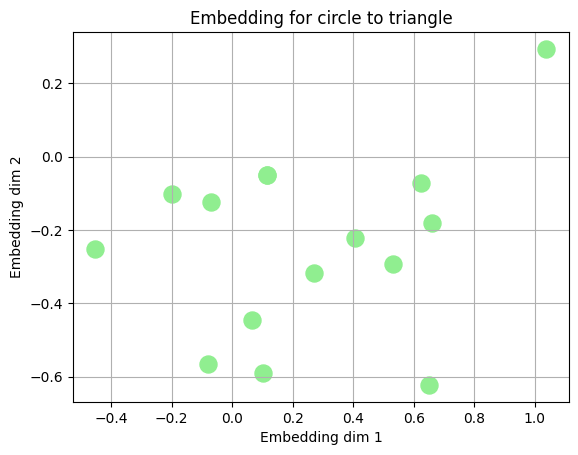

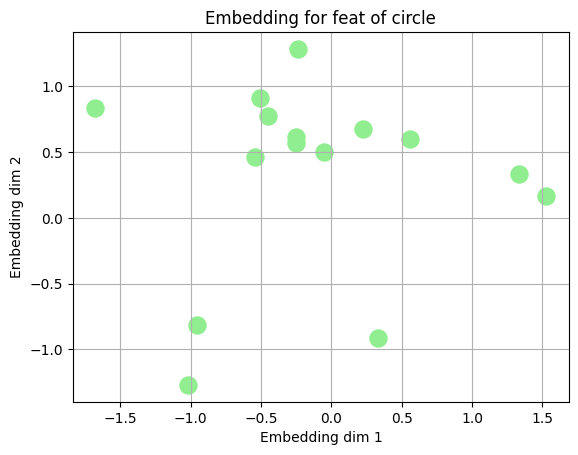

In [59]:

data = coarsener.summarized_graph.nodes['circle'].data['hto_triangle']
# Extract x and y coordinates
x = data[:, 0].numpy()
y = data[:, 1].numpy()

# Create scatter plot
plt.scatter(x, y, color='lightgreen', s=150)
plt.title("Embedding for circle to triangle")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.grid(True)
plt.savefig('plots/emb_cir_tri')
plt.show()


data = coarsener.summarized_graph.nodes['circle'].data['feat']
# Extract x and y coordinates
x = data[:, 0].numpy()
y = data[:, 1].numpy()

# Create scatter plot
plt.scatter(x, y, color='lightgreen', s=150)
plt.title("Embedding for feat of circle")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.grid(True)
plt.savefig('plots/emb_cir')
plt.show()

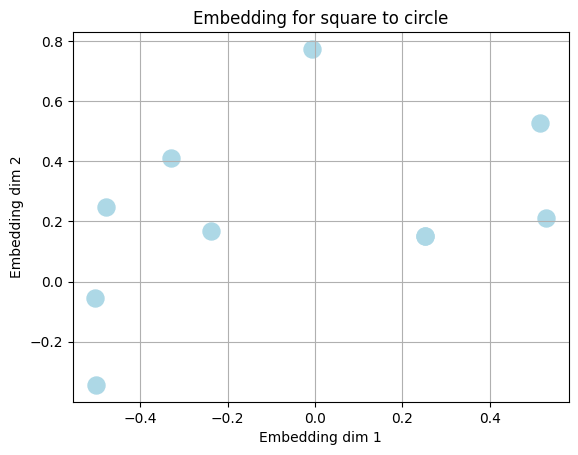

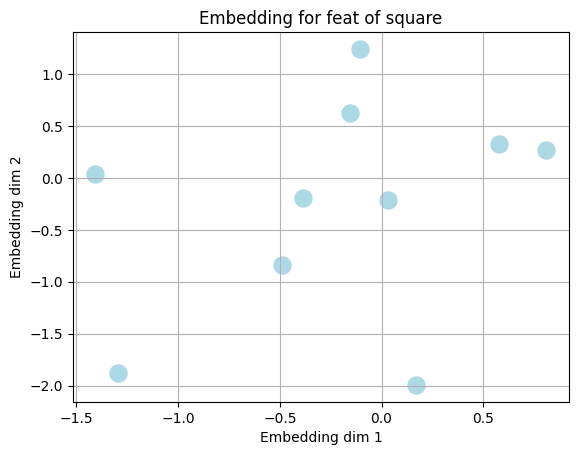

In [60]:

data = coarsener.summarized_graph.nodes['square'].data['hto_circle']
# Extract x and y coordinates
x = data[:, 0].numpy()
y = data[:, 1].numpy()

# Create scatter plot
plt.scatter(x, y, color='lightblue', s=150)
plt.title("Embedding for square to circle")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.grid(True)
plt.savefig('plots/emb_squ_cir')
plt.show()


data = coarsener.summarized_graph.nodes['square'].data['feat']
# Extract x and y coordinates
x = data[:, 0].numpy()
y = data[:, 1].numpy()

# Create scatter plot
plt.scatter(x, y, color='lightblue', s=150)
plt.title("Embedding for feat of square")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.grid(True)
plt.savefig('plots/emb_squ')
plt.show()

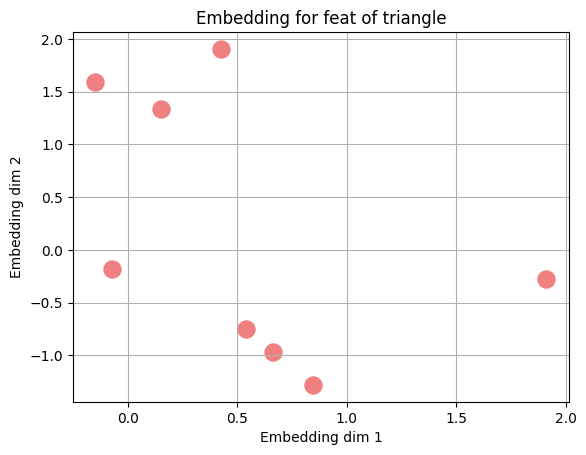

In [61]:


data = coarsener.summarized_graph.nodes['triangle'].data['feat']
# Extract x and y coordinates
x = data[:, 0].numpy()
y = data[:, 1].numpy()

# Create scatter plot
plt.scatter(x, y, color='lightcoral', s=150)
plt.title("Embedding for feat of triangle")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.grid(True)
plt.savefig('plots/emb_tri')
plt.show()

In [30]:
#original_graph = dataset.load_graph(n_components = 50)
from Projections.JLRandom import JLRandomProjection
device = 'cpu'
original_graph = hetero_g.to(device=device)
from Projections.CCA import CCA

num_nearest_init_neighbors_per_type = {"to_circle": 3, "circle": 3, "square":3, "to_triangle":3, "triangle":3}
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, use_zscore=True,device=device,
                                 batch_size=None, checkpoints=[0.9, 0.5, 0.3],
                                pairs_per_level=2,norm_p=1, approx_neigh=True, add_feat=False, use_out_degree=False) 
#, batch_size=4096
coarsener.init()
coarsener.summarize()


to_triangle
to_circle


/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


KeyError: 'costs_h_to_triangle'